In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np

ms_df = pd.read_csv(filepath_or_buffer="ms.csv")
#ms_df["text"].head(5)
WIKI_LOOKUP = open("wiki_lookup.json")
wiki = json.load(WIKI_LOOKUP)
ms_df["page_length"] = [len(wiki[page]["text"]) for page in ms_df["page"]]

In [2]:
human_cols = [col for col in ms_df.columns if "human_" in col]
computer_cols = [col for col in ms_df.columns if "computer_" in col]

def row_to_converted_df(row):
    
    new_row = row.drop(labels=human_cols+computer_cols)
    new_rows = pd.concat([pd.DataFrame([new_row]) for i in range(12)]).reset_index(drop=True)
    
    author = []
    clue_number = []
    start_inds = []
    guessed_answer = []
    
    for auth in ["human", "computer"]:
        for i in range(6):
            author.append(auth)
            clue_number.append(i)
            start_inds.append(row[f"{auth}_start_index_{i}"])
            guessed_answer.append(row[f"{auth}_answer_{i}"])
    
    new_cols = pd.concat({"author": pd.Series(author),
                     "clue_number": pd.Series(clue_number),
                     "start_index": pd.Series(start_inds),
                     "guessed_answer": pd.Series(guessed_answer)}, axis="columns")
    return pd.concat([new_rows, new_cols], axis="columns")

def convert_df(ms_df):
    rows = []

    count = 0
    for index, row in ms_df.iterrows():
        count += 1
        rows.append(row_to_converted_df(row))
    return pd.concat(rows)

new_ms_df = convert_df(ms_df).reset_index(drop=True)
new_ms_df.to_csv("ms_updated.csv")
ms_df = new_ms_df

In [3]:
from fuzzywuzzy import fuzz
import string
import math
# print(ms_df.columns)
def is_correct_answer(real_answer, model_answer):
    real_answer = real_answer.replace("_", " ")
    model_answer = ' '.join(model_answer.split(' ')[:min(model_answer.count(" ") + 1, real_answer.count(" ") + 1)])
    if fuzz.ratio(real_answer, model_answer) > 50:
        return True        
    # for word in model_answer:
    #     if fuzz.ratio(real_answer, word) > 90:
    #         return True
    return False

# ms_df = pd.concat(list(ms_df, pd.Series(len(ms_df) * [True], ["is_correct"])), axis="columns")
# for index, row in ms_df.iterrows():
# ms_df["is_correct"] = np.where(not isinstance(ms_df[f"guessed_answer"], float) and (not is_correct_answer(ms_df["page"], ms_df[f"guessed_answer"])), False, True)
ms_df["is_correct"] = True
for index, row in ms_df.iterrows():            
    if isinstance(row[f"guessed_answer"], float):
        ms_df.loc[index, f"is_correct"] = "No Answer"
    elif not is_correct_answer(row["page"], row[f"guessed_answer"]):
        ms_df.loc[index, f"is_correct"] = False
df2 = ms_df[["author", "clue_number", "start_index", "page", "guessed_answer", "is_correct"]]
df2.to_csv("test.csv")
df2.to_csv("full.csv")

In [7]:
ms_df["percentage_of_page"] = 100 * ms_df["start_index"] / ms_df["page_length"]
ms_df["percentage_of_page"]

0        5.752451
1       28.611440
2       32.780351
3             NaN
4             NaN
          ...    
6955     0.071065
6956     0.418911
6957    35.794434
6958    42.242669
6959          NaN
Name: percentage_of_page, Length: 6960, dtype: float64

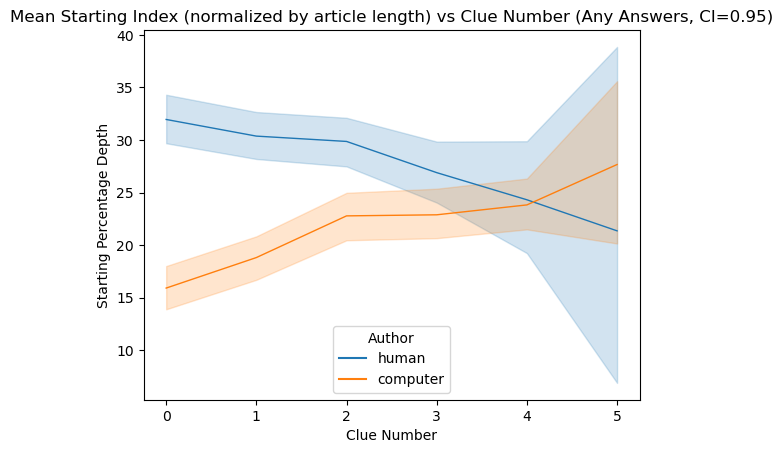

In [47]:
ax = sns.lineplot(data=ms_df, estimator="mean",
             x="clue_number", y="percentage_of_page", hue="author",
             linewidth=1)
ax.set_title("Mean Starting Index (normalized by article length) vs Clue Number (Any Answers, CI=0.95)")
ax.set_xlabel("Clue Number")
ax.set_ylabel("Starting Percentage Depth")
ax.legend(loc='lower center', title="Author")

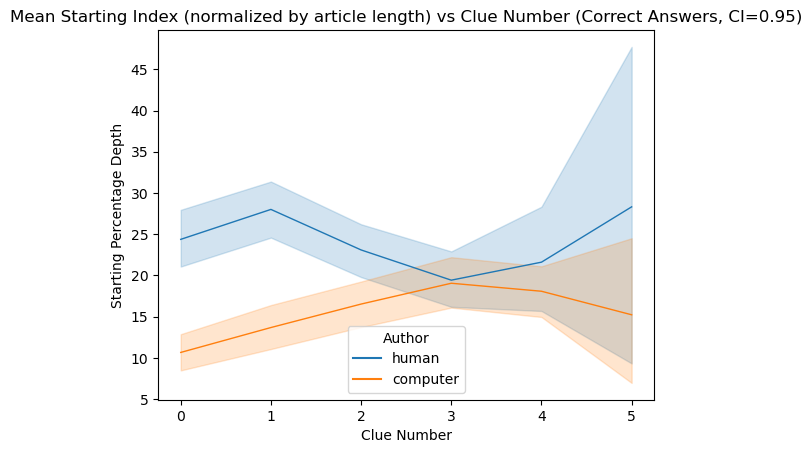

In [48]:
correct_answers_df = ms_df[ms_df["is_correct"] == True]
ax2 = sns.lineplot(data=correct_answers_df, estimator="mean",
             x="clue_number", y="percentage_of_page", hue="author",
             linewidth=1)
ax2.set_title("Mean Starting Index (normalized by article length) vs Clue Number (Correct Answers, CI=0.95)")
ax2.set_xlabel("Clue Number")
ax2.set_ylabel("Starting Percentage Depth")
ax2.legend(loc='lower center', title="Author")

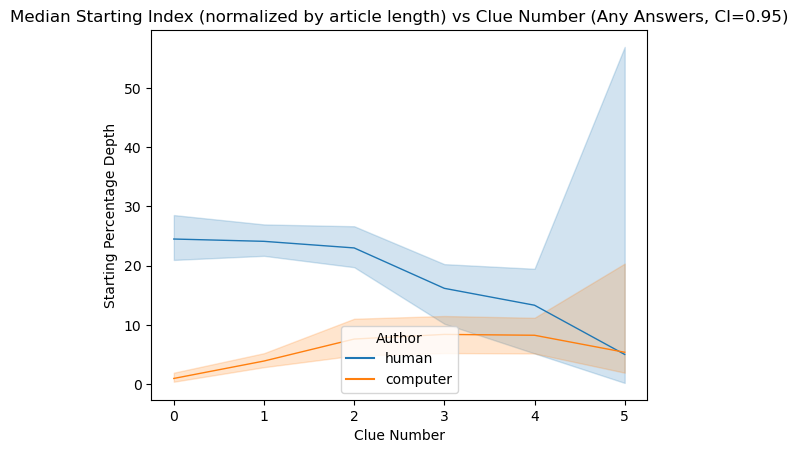

In [33]:
ax = sns.lineplot(data=ms_df, estimator="median",
             x="clue_number", y="percentage_of_page", hue="author",
             linewidth=1)
ax.set_title("Median Starting Index (normalized by article length) vs Clue Number (Any Answers, CI=0.95)")
ax.set_xlabel("Clue Number")
ax.set_ylabel("Starting Percentage Depth")
ax.legend(loc='lower center', title="Author")

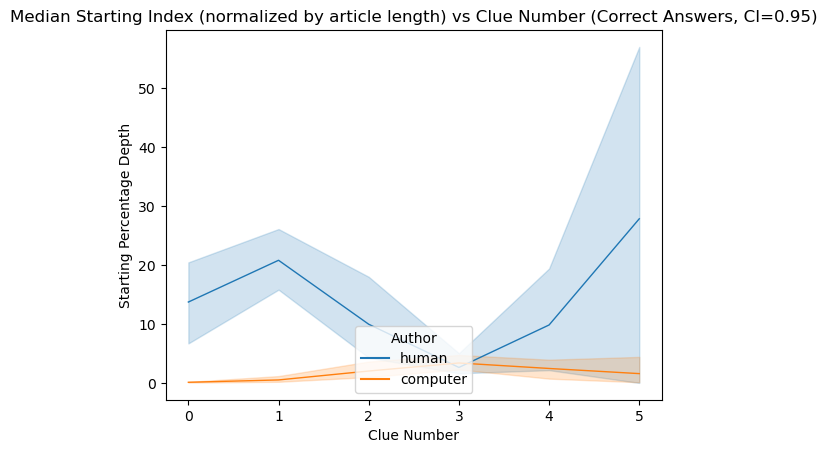

In [44]:
correct_answers_df = ms_df[ms_df["is_correct"] == True]
ax = sns.lineplot(data=correct_answers_df, estimator="median",
             x="clue_number", y="percentage_of_page", hue="author",
             linewidth=1)
ax.set_xlabel("Clue Number")
ax.set_ylabel("Starting Percentage Depth")
ax.set_title("Median Starting Index (normalized by article length) vs Clue Number (Correct Answers, CI=0.95)")
ax.legend(loc='lower center', title="Author")

[None]

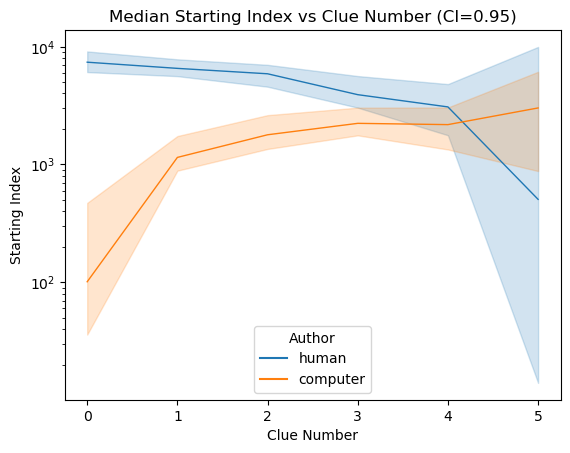

In [52]:
ax = sns.lineplot(data=ms_df, estimator="median",
             x="clue_number", y="start_index", hue="author",
             linewidth=1)
ax.set_title("Median Starting Index vs Clue Number (CI=0.95)")
ax.set_xlabel("Clue Number")
ax.set_ylabel("Starting Index")
ax.legend(loc='lower center', title="Author")
ax.set(yscale='log')

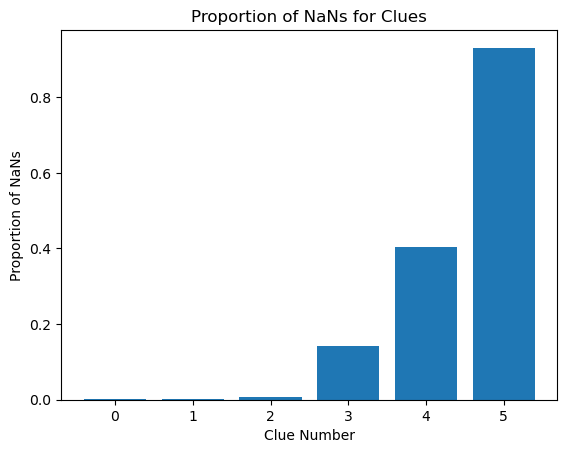

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_nan_proportion(df):
    # Group the dataframe by clue_number
    df_grouped = df.groupby('clue_number')
    
    # Initialize an empty list to store the relative proportion of nans for each group
    nan_proportions = []
    
    # Iterate over the groups
    for name, group in df_grouped:
        # Count the number of nans in the start_index column
        nan_count = group['start_index'].isnull().sum()
        # Calculate the relative proportion of nans
        nan_proportion = nan_count / len(group)
        # Add the nan proportion to the list
        nan_proportions.append(nan_proportion)
    
    # Get the clue_numbers for each group
    clue_numbers = df_grouped.groups.keys()
    
    # Create a bar plot showing the relative proportion of nans for each clue_number
    ax = plt.bar(x=clue_numbers, height=nan_proportions)
    plt.title("Proportion of NaNs for Clues")
    plt.xlabel('Clue Number')
    plt.ylabel('Proportion of NaNs')
    plt.show()

plot_nan_proportion(ms_df)

[None]

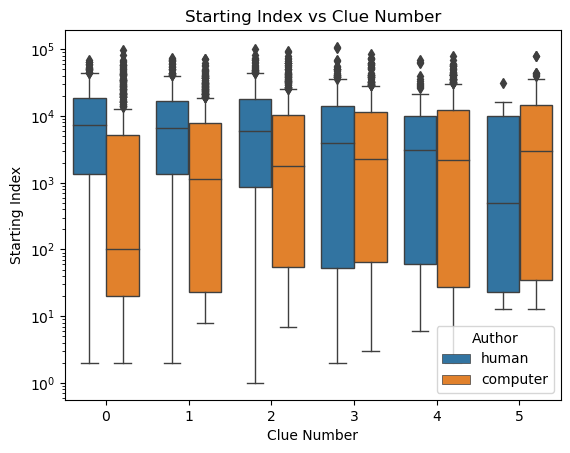

In [56]:
ax = sns.boxplot(data=ms_df,
             x="clue_number", y="start_index", hue="author",
             linewidth=1)
ax.set_title("Starting Index vs Clue Number")
ax.set_xlabel("Clue Number")
ax.set_ylabel("Starting Index")
ax.legend(loc='lower right', title="Author")
ax.set(yscale='log')

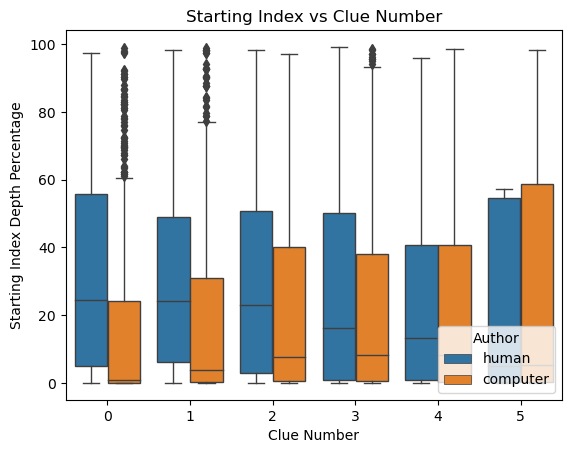

In [55]:
ax = sns.boxplot(data=ms_df,
             x="clue_number", y="percentage_of_page", hue="author",
             linewidth=1)
ax.set_title("Starting Index vs Clue Number")
ax.set_xlabel("Clue Number")
ax.set_ylabel("Starting Index Depth Percentage")
ax.legend(loc='lower right', title="Author")

In [35]:
# sns.countplot(data=ms_df[ms_df["start_index"] < 500], x="author")
ms_df[(ms_df["start_index"] < 500) & (ms_df["author"] == "human")]

,Unnamed: 0,text,answer,page,category,difficulty,qanta_id,fold,page_length,author,clue_number,start_index,guessed_answer,is_correct,percentage_of_page
38,19683,This character was named after the wife of Kin...,Hermione Granger [accept either],Hermione_Granger,Literature,MS,21388,guesstrain,24352,human,2,35.0,hermione granger hermione jean granger ( ) is ...,True,0.143725
48,19771,Three square windows can be seen in the back o...,The {Last Supper},Last_Supper,Fine Arts,MS,21486,guesstrain,22085,human,0,2.0,three square windows can be seen in the back o...,False,0.009056
62,19772,"The ""law of"" these objects states that the tor...",levers,Lever,Science,MS,21487,guesstrain,6609,human,2,99.0,six,False,1.497957
132,19778,This man composed a ballet called The Creature...,Ludwig von {Beethoven},Ludwig_van_Beethoven,Fine Arts,MS,21493,guesstrain,43789,human,0,53.0,ludwig van beethoven,True,0.121035
144,19779,The oldest person to hold this position was Ro...,{Chief Justice} of the Supreme Court,Chief_Justice,History,MS,21494,guesstrain,3118,human,0,440.0,roger taney,False,14.111610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,40067,This character becomes his team's leader after...,Buck,Bucky_Lasek,Literature,MS,44270,guesstrain,2024,human,2,25.0,"bucky lasek charles "" bucky "" lasek ( ; born d...",True,1.235178
6891,40067,This character becomes his team's leader after...,Buck,Bucky_Lasek,Literature,MS,44270,guesstrain,2024,human,3,32.0,bucky lasek,True,1.581028
6901,40068,"This singer claims ""I'd wait for you forever a...",Justin Bieber,Justin_Bieber,Trash,MS,44271,guesstrain,34209,human,1,2.0,"big sean wonders "" i don't know if this makes ...",False,0.005846
6903,40068,"This singer claims ""I'd wait for you forever a...",Justin Bieber,Justin_Bieber,Trash,MS,44271,guesstrain,34209,human,3,24.0,justin bieber justin drew bieber,True,0.070157
